In [1]:
# Import Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [2]:
import pathlib

# Read in dataset
data_dir_train = pathlib.Path('insects/train')
data_dir_test = pathlib.Path('insects/test')

In [3]:
batch_size = 32
img_height = 180
img_width = 180

# Create Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Create Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1019 files belonging to 3 classes.
Found 180 files belonging to 3 classes.


In [4]:
# Check the class names
class_names = train_ds.class_names
print(class_names)

['beetles', 'cockroach', 'dragonflies']


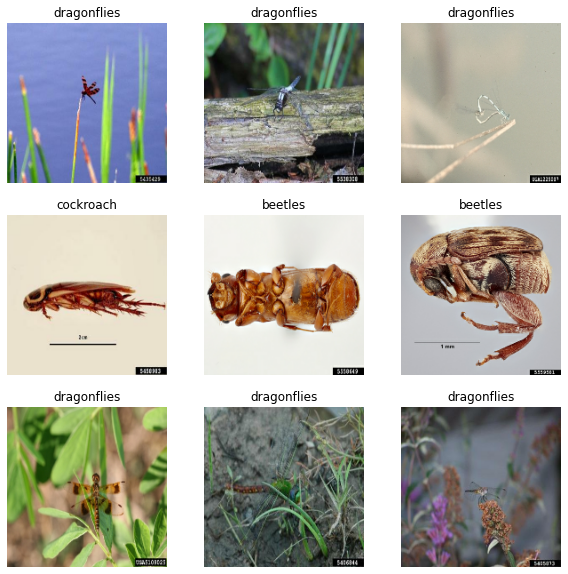

In [5]:
# Show some sample pictures
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Check the shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99995786


In [10]:
num_classes = 3

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:
# Fit the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
32/32 [==============================] - 14s 423ms/step - loss: 1.0415 - accuracy: 0.6104 - val_loss: 0.7377 - val_accuracy: 0.7000
Epoch 2/10
32/32 [==============================] - 13s 422ms/step - loss: 0.4814 - accuracy: 0.8106 - val_loss: 0.5255 - val_accuracy: 0.8222
Epoch 3/10
32/32 [==============================] - 13s 409ms/step - loss: 0.3238 - accuracy: 0.8832 - val_loss: 0.3965 - val_accuracy: 0.8667
Epoch 4/10
32/32 [==============================] - 13s 405ms/step - loss: 0.2219 - accuracy: 0.9205 - val_loss: 0.2906 - val_accuracy: 0.9000
Epoch 5/10
32/32 [==============================] - 13s 406ms/step - loss: 0.1695 - accuracy: 0.9342 - val_loss: 0.1406 - val_accuracy: 0.9722
Epoch 6/10
32/32 [==============================] - 13s 404ms/step - loss: 0.1004 - accuracy: 0.9696 - val_loss: 0.0835 - val_accuracy: 0.9833
Epoch 7/10
32/32 [==============================] - 13s 410ms/step - loss: 0.0595 - accuracy: 0.9823 - val_loss: 0.0503 - val_accuracy: 0.9778

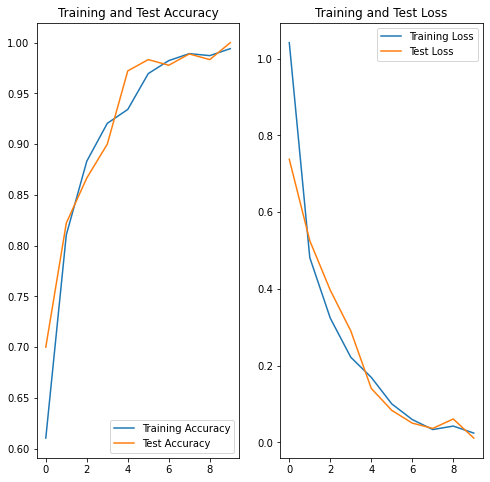

In [14]:
# Plot the accuracy and the loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

In [24]:
# Check the model by a random picture of dragonfly from Google
pic = "Random_Dragonfly.jpg"

img = tf.keras.utils.load_img(
    pic, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dragonflies with a 83.99 percent confidence.


In [16]:
# SHAP
import shap

In [17]:
# Convert to matrix
x_train = np.concatenate([x for x , y in train_ds], axis = 0)
y_train = np.concatenate([y for x , y in train_ds], axis = 0)

x_test = np.concatenate([x for x , y in test_ds], axis = 0)
y_test = np.concatenate([y for x , y in test_ds], axis = 0)

(180, 180, 180, 3)

In [18]:
x_train.shape

(1019, 180, 180, 3)

In [19]:
explainer = shap.GradientExplainer(model, x_train)

In [20]:
# Calculate shap values
sv = explainer.shap_values(x_test[:20])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [23]:
len(y_test)

180

     Reference            Beetles            Cockroach            Dragonflies


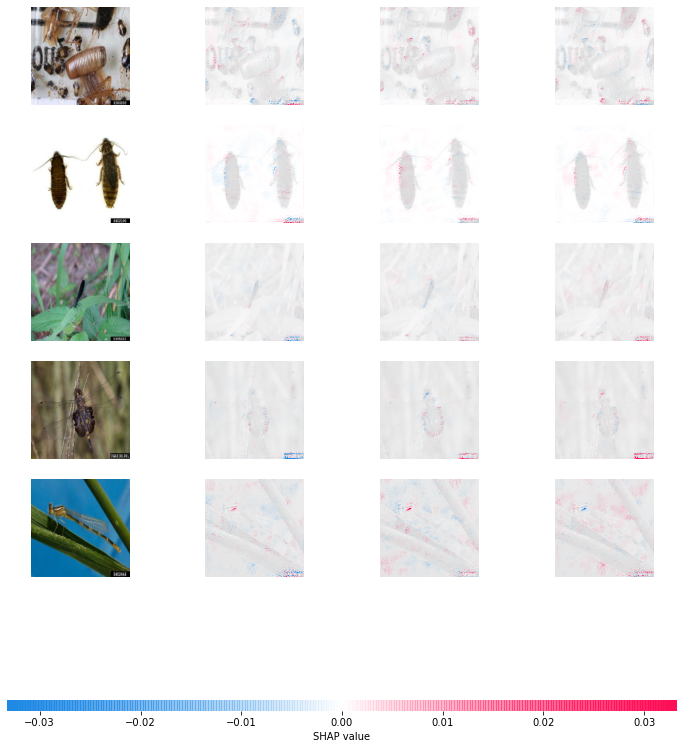

In [22]:
print("     Reference            Beetles            Cockroach            Dragonflies")
shap.image_plot([sv[i] for i in range(3)], x_test[0:5])